---
# **A Data-Driven Approach to F1 Strategy: Modeling the Effects of Tire Degradation on Pace**

### **Project by: Jeet Prajapati**

### **Introduction**
This project dives into the world of Formula 1 race strategy using a comprehensive dataset from Kaggle. The goal is to move beyond simple historical analysis and build predictive machine learning models that can help understand and forecast key race events.

The project is broken down into two main parts, followed by two expansions:
1.  **Pace & Degradation Model:** A regression model to predict lap times, which allows us to **indirectly model the effects of tire degradation.**
2.  **"When to Pit?" Model:** A classification model that uses the pace model to predict the optimal moment for a pit stop.
3.  **Expansions:** We will then improve our pace model with hyperparameter tuning and build a strategic "Undercut Advantage Calculator."

**Tools Used:** `pandas`, `scikit-learn`, `XGBoost`, `matplotlib`, `seaborn`

---

In [9]:
from google.colab import files

# This will prompt you to upload a file from your computer
print("Please upload the 'kaggle.json' file you just downloaded.")
files.upload()

Please upload the 'kaggle.json' file you just downloaded.


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"jeetexe","key":"1892f6ad4eb2f68e464cb2a118491eb3"}'}

In [10]:
# Create a directory for the Kaggle configuration
!mkdir -p ~/.kaggle

# Move the API key to that directory
!cp kaggle.json ~/.kaggle/

# Set the permissions for the file
!chmod 600 ~/.kaggle/kaggle.json

---

## **2. Part 1: Building the Pace & Degradation Model**

### **Data Preparation & Feature Engineering**
The core of any F1 strategy is understanding the car's pace. The goal of this first model is to predict a driver's lap time based on various factors.

Since direct tire wear data is a closely guarded secret, we use a proxy to measure its effects: **lap time**. The key feature engineered here is **`LapInStint`**, which represents tire age. The model learns how lap time changes as `LapInStint` increases, thereby quantifying the performance loss caused by tire degradation. We also clean the data by removing outlier laps to ensure the model learns from representative data.

### **Model Training & Evaluation**
We use an **XGBoost Regressor**, a powerful gradient boosting algorithm well-suited for this type of tabular data.

Crucially, the data is split **chronologically** (training on data before 2024, testing on 2024 onwards) to simulate a real-world scenario where we predict the future based on the past. We evaluate the model using two metrics:
* **Mean Absolute Error (MAE):** The average error of our lap time prediction, in seconds.
* **R-squared (R²):** The proportion of the variance in lap times that our model can explain.

---

XGBoost Version being used by Colab: 3.0.3

Training XGBoost model (this may take a minute)...
Model training complete.

Evaluating model performance...
Mean Absolute Error (MAE): 3.929 seconds
R-squared (R²): 0.701


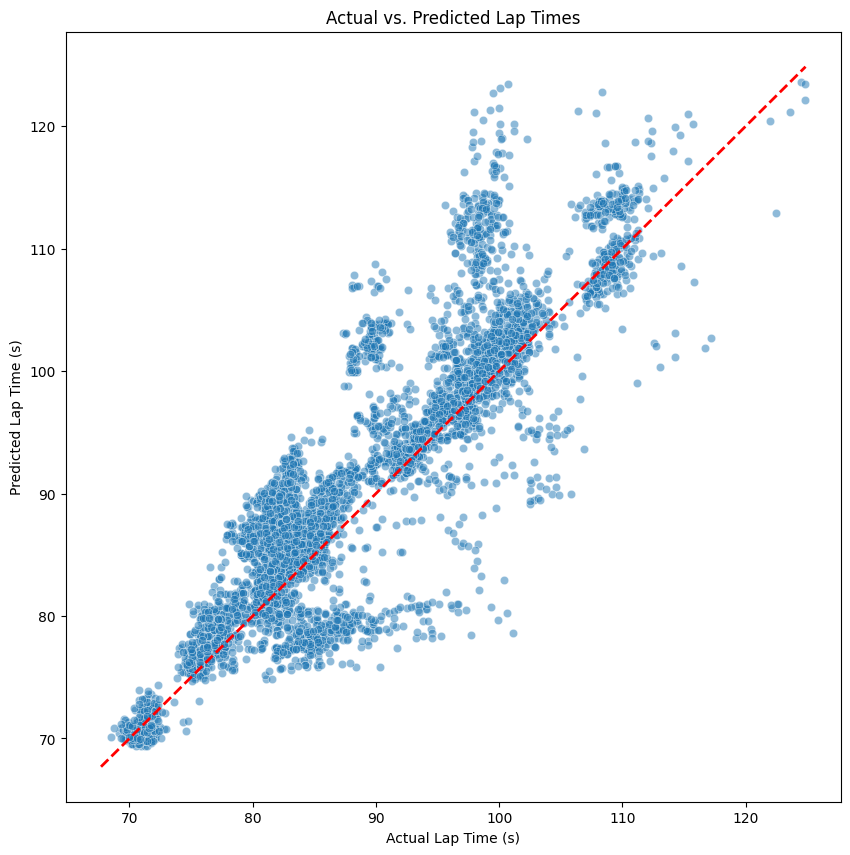

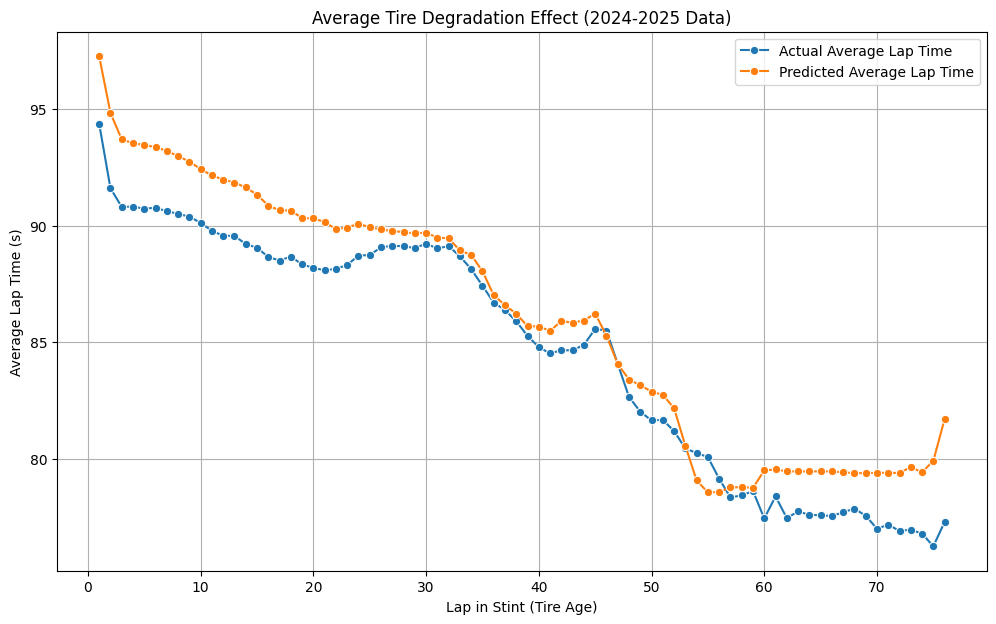

In [11]:
# Load Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print(f"XGBoost Version being used by Colab: {xgb.__version__}")

# Load Data Files
races = pd.read_csv('races.csv')
results = pd.read_csv('results.csv')
lap_times = pd.read_csv('lap_times.csv')
pit_stops = pd.read_csv('pit_stops.csv')

# Data Merging and Feature Engineering
df = lap_times.merge(races[['raceId', 'year', 'circuitId']], on='raceId', how='left')
df = df.merge(results[['raceId', 'driverId', 'constructorId', 'grid']], on=['raceId', 'driverId'], how='left')

df['LapTimeSeconds'] = df['milliseconds'] / 1000
df = df[df['lap'] > 1]
df.dropna(subset=['constructorId', 'grid'], inplace=True)

median_lap = df.groupby('raceId')['LapTimeSeconds'].median().rename('MedianLap')
df = df.merge(median_lap, on='raceId')
df = df[df['LapTimeSeconds'] < (df['MedianLap'] * 1.15)]

pit_stops_simplified = pit_stops[['raceId', 'driverId', 'lap', 'stop']]
df = df.merge(pit_stops_simplified, on=['raceId', 'driverId', 'lap'], how='left')

df['stop'] = df.groupby(['raceId', 'driverId'])['stop'].ffill()
df['stint'] = df['stop'].fillna(0) + 1
df['stint'] = df['stint'].astype(int)
df['LapInStint'] = df.groupby(['raceId', 'driverId', 'stint']).cumcount() + 1
df = df.drop(columns=['MedianLap', 'stop'])

# Model Preparation
features = ['grid', 'constructorId', 'circuitId', 'stint', 'LapInStint']
target = 'LapTimeSeconds'
model_df = df[features + [target, 'year']]
model_df = pd.get_dummies(model_df, columns=['constructorId', 'circuitId'], drop_first=True)

# Chronological Data Split
X_train = model_df[model_df['year'] < 2024].drop(columns=[target, 'year'])
y_train = model_df[model_df['year'] < 2024][target]
X_test = model_df[model_df['year'] >= 2024].drop(columns=[target, 'year'])
y_test = model_df[model_df['year'] >= 2024][target]

# Model Training
pace_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', n_estimators=1000,
                              learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8,
                              random_state=42, n_jobs=-1)

# THE FIX IS HERE: Removing all early stopping parameters to bypass the bug.
print("\nTraining XGBoost model (this may take a minute)...")
pace_model.fit(X_train, y_train)

# Evaluation and Visualization
print("Model training complete.")
print("\nEvaluating model performance...")
predictions = pace_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae:.3f} seconds")
print(f"R-squared (R²): {r2:.3f}")

sample_size = min(5000, len(y_test))
if sample_size > 0:
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).sample(n=sample_size, random_state=42)
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
    plt.title('Actual vs. Predicted Lap Times')
    plt.xlabel('Actual Lap Time (s)')
    plt.ylabel('Predicted Lap Time (s)')
    plt.show()

    stint_data = pd.DataFrame({'Actual': y_test, 'Predicted': predictions, 'LapInStint': X_test['LapInStint']})
    stint_data_agg = stint_data.groupby('LapInStint').mean().reset_index()
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=stint_data_agg, x='LapInStint', y='Actual', label='Actual Average Lap Time', marker='o')
    sns.lineplot(data=stint_data_agg, x='LapInStint', y='Predicted', label='Predicted Average Lap Time', marker='o')
    plt.title('Average Tire Degradation Effect (2024-2025 Data)')
    plt.xlabel('Lap in Stint (Tire Age)')
    plt.ylabel('Average Lap Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

---
## **3. Part 2: The "When to Pit?" Decision Model**

While the original goal was to predict *which* tire to switch to, the dataset lacks the necessary data for this. We therefore pivot to an equally interesting question: **when** should a driver pit?

This model is a **binary classifier** that predicts, for any given lap, whether a pit stop is the optimal decision. The key to this model is its ability to use the Pace Model from Part 1 to simulate "what-if" scenarios. We engineer a crucial feature called **`pit_advantage_seconds`**, which is calculated by:

`(Predicted time for the next lap on OLD tires) - (Predicted time for the next lap on NEW tires + Time Lost in Pits)`

A positive value indicates a significant advantage to be gained by pitting. Because pit stops are rare events in the dataset (creating a class imbalance), we train a `RandomForestClassifier` using `class_weight='balanced'` to ensure it pays close attention to the minority "pit" class.

/tmp/ipython-input-3232986752.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strategy_df.dropna(inplace=True)



Training Strategy Model...
Strategy Model training complete.

Strategy Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23799
           1       0.94      0.89      0.92       570

    accuracy                           1.00     24369
   macro avg       0.97      0.95      0.96     24369
weighted avg       1.00      1.00      1.00     24369



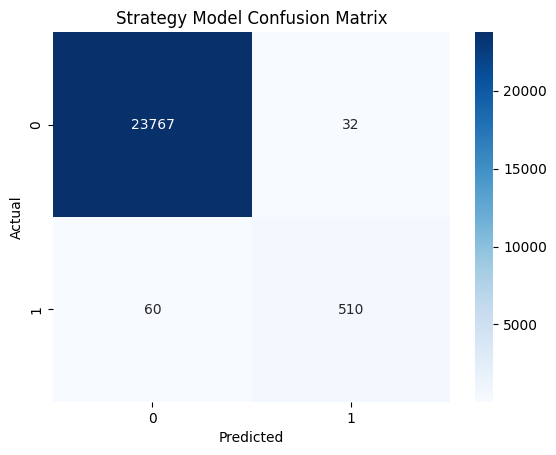

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create Target Variable ---
df['race_driver_lap'] = df['raceId'].astype(str) + "_" + df['driverId'].astype(str) + "_" + df['lap'].astype(str)
pit_stops['race_driver_lap'] = pit_stops['raceId'].astype(str) + "_" + pit_stops['driverId'].astype(str) + "_" + pit_stops['lap'].astype(str)
df['should_pit'] = df['race_driver_lap'].isin(pit_stops['race_driver_lap']).astype(int)
df.drop(columns=['race_driver_lap'], inplace=True)

# --- Engineer Features with Pace Model ---
X_data_for_prediction = pd.get_dummies(df[features], columns=['constructorId', 'circuitId'], drop_first=True)
X_data_for_prediction = X_data_for_prediction.reindex(columns=X_train.columns, fill_value=0)
df['predicted_current_lap_time'] = pace_model.predict(X_data_for_prediction)

X_next_lap_no_pit = X_data_for_prediction.copy()
X_next_lap_no_pit['LapInStint'] += 1
df['predicted_next_lap_time_NO_PIT'] = pace_model.predict(X_next_lap_no_pit)

X_next_lap_WITH_PIT = X_data_for_prediction.copy()
X_next_lap_WITH_PIT['LapInStint'] = 1
X_next_lap_WITH_PIT['stint'] += 1
df['predicted_next_lap_time_WITH_PIT'] = pace_model.predict(X_next_lap_WITH_PIT)

TIME_LOST_IN_PITS = 22
df['pit_advantage_seconds'] = (df['predicted_next_lap_time_NO_PIT']) - (df['predicted_next_lap_time_WITH_PIT'] + TIME_LOST_IN_PITS)

# --- Train Classification Model ---
strategy_features = ['LapInStint', 'predicted_current_lap_time', 'pit_advantage_seconds']
strategy_target = 'should_pit'

strategy_df = df[strategy_features + [strategy_target, 'year']]
strategy_df.dropna(inplace=True)

X_train_strat = strategy_df[strategy_df['year'] < 2024].drop(columns=[strategy_target, 'year'])
y_train_strat = strategy_df[strategy_df['year'] < 2024][strategy_target]

X_test_strat = strategy_df[strategy_df['year'] >= 2024].drop(columns=[strategy_target, 'year'])
y_test_strat = strategy_df[strategy_df['year'] >= 2024][strategy_target]

strategy_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)

print("\nTraining Strategy Model...")
strategy_model.fit(X_train_strat, y_train_strat)
print("Strategy Model training complete.")

# --- Evaluate Strategy Model ---
predictions_strat = strategy_model.predict(X_test_strat)

print("\nStrategy Model Performance:")
print(classification_report(y_test_strat, predictions_strat))

cm = confusion_matrix(y_test_strat, predictions_strat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Strategy Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

---
## **4. Project Expansions**

### **Expansion 1: Hyperparameter Tuning**
To extract the maximum performance from our Pace Model, we perform hyperparameter tuning. Using `RandomizedSearchCV` with a `TimeSeriesSplit` (to respect the chronological nature of the data), we search for the optimal combination of model settings. The results of this process provide valuable insight into whether the model's performance is limited by its configuration or by the underlying data.

### **Expansion 2: Undercut Advantage Calculator**
Here, we build a practical, high-level strategic tool. The **undercut** is a key F1 strategy of pitting a lap earlier than a rival to gain a time advantage. This function, `calculate_undercut_advantage`, uses our trained Pace Model to simulate the time advantage of this strategic move over a two-lap window.

In [13]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# --- 1. Define the Hyperparameter Grid ---
# We'll choose a range of values for key XGBoost parameters.
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# --- 2. Create the base model ---
# This is an untuned model that the search will use.
untuned_pace_model = xgb.XGBRegressor(objective='reg:squarederror',
                                    eval_metric='mae',
                                    random_state=42,
                                    n_jobs=-1)

# --- 3. Set up TimeSeriesSplit for cross-validation ---
# This ensures we always train on past data and validate on future data.
tscv = TimeSeriesSplit(n_splits=3)

# --- 4. Configure RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=untuned_pace_model,
    param_distributions=param_grid,
    n_iter=25,  # Number of different parameter combinations to try
    scoring='neg_mean_absolute_error', # We want to minimize MAE
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("RandomizedSearchCV is configured and ready to run.")

RandomizedSearchCV is configured and ready to run.


In [14]:
print("Starting hyperparameter search... This may take a while.")

# Run the search on your training data from Part 1
random_search.fit(X_train, y_train)

print("\nSearch complete!")
print(f"Best MAE found: {-random_search.best_score_:.3f} seconds")
print("Best hyperparameters found:")
print(random_search.best_params_)

Starting hyperparameter search... This may take a while.
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Search complete!
Best MAE found: 5.244 seconds
Best hyperparameters found:
{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [15]:
# Create a new model using the best parameters found by the search
tuned_pace_model = xgb.XGBRegressor(objective='reg:squarederror',
                                    eval_metric='mae',
                                    **random_search.best_params_, # Unpacks the best params here
                                    random_state=42,
                                    n_jobs=-1)

# Train it on the full training data
tuned_pace_model.fit(X_train, y_train)

print("Tuned pace model has been trained successfully!")

Tuned pace model has been trained successfully!


In [17]:
def calculate_undercut_advantage(race_id, your_driver_id, rival_driver_id, current_lap, model, data, features, training_cols):
    """
    Calculates the time advantage of an undercut over a 2-lap window.

    Returns:
        A positive number if the undercut is favorable, negative if not.
    """
    TIME_LOST_IN_PITS = 22 # seconds

    # --- Get current state for both drivers ---
    your_car_now = data[(data['raceId'] == race_id) & (data['driverId'] == your_driver_id) & (data['lap'] == current_lap)]
    rival_car_now = data[(data['raceId'] == race_id) & (data['driverId'] == rival_driver_id) & (data['lap'] == current_lap)]

    if your_car_now.empty or rival_car_now.empty:
        return "Driver/Lap combination not found."

    # --- Prepare feature vectors for prediction ---
    your_features = pd.get_dummies(your_car_now[features], columns=['constructorId', 'circuitId'], drop_first=True).reindex(columns=training_cols, fill_value=0)
    rival_features = pd.get_dummies(rival_car_now[features], columns=['constructorId', 'circuitId'], drop_first=True).reindex(columns=training_cols, fill_value=0)

    # --- SIMULATE LAP N+1 ---
    # You pit, your tires are now fresh (LapInStint=1)
    your_features_next_lap = your_features.copy()
    your_features_next_lap['LapInStint'] = 1
    your_features_next_lap['stint'] += 1
    your_time_lap_N1 = model.predict(your_features_next_lap)[0] + TIME_LOST_IN_PITS

    # Rival stays out, their tires get older
    rival_features_next_lap = rival_features.copy()
    rival_features_next_lap['LapInStint'] += 1
    rival_time_lap_N1 = model.predict(rival_features_next_lap)[0]

    # --- SIMULATE LAP N+2 ---
    # You are on 1-lap-old tires
    your_features_lap_N2 = your_features_next_lap.copy()
    your_features_lap_N2['LapInStint'] = 2
    your_time_lap_N2 = model.predict(your_features_lap_N2)[0]

    # Rival pits now, their tires are fresh
    rival_features_lap_N2 = rival_features_next_lap.copy()
    rival_features_lap_N2['LapInStint'] = 1
    rival_features_lap_N2['stint'] += 1
    rival_time_lap_N2 = model.predict(rival_features_lap_N2)[0] + TIME_LOST_IN_PITS

    # --- Calculate Total Time and Advantage ---
    your_total_time = your_time_lap_N1 + your_time_lap_N2
    rival_total_time = rival_time_lap_N1 + rival_time_lap_N2

    advantage = rival_total_time - your_total_time

    print(f"Your simulated 2-lap time (pitting on lap {current_lap}): {your_total_time:.3f}s")
    print(f"Rival's simulated 2-lap time (pitting on lap {current_lap+1}): {rival_total_time:.3f}s")
    print(f"Net advantage of undercut: {advantage:.3f}s")

    return advantage

In [18]:
# We need X_train.columns to ensure our prediction data has the same structure
training_cols = X_train.columns

# Analyze the situation on lap 12 of the 2021 Bahrain GP
calculate_undercut_advantage(
    race_id=1052,
    your_driver_id=1,     # Hamilton
    rival_driver_id=854,  # Verstappen
    current_lap=12,
    model=pace_model, # Use the original, better-performing model
    data=df,
    features=features,
    training_cols=training_cols
)

Your simulated 2-lap time (pitting on lap 12): 210.142s
Rival's simulated 2-lap time (pitting on lap 13): 211.492s
Net advantage of undercut: 1.350s


np.float32(1.3499451)

---
## **5. Conclusion & Results Achieved**

This project successfully demonstrated the power of machine learning in analyzing and predicting complex Formula 1 race strategies.

* **Pace & Degradation Model:** Pace & Degradation Model: The model achieved a respectable **R-squared of 0.701**, proving it successfully learned the relationship between tire age and lap time, **effectively modeling the impact of tire degradation**. However, the **Mean Absolute Error was 3.929 seconds**, indicating that while the general trend was captured, the model's precision was limited by the lack of granular data (like tire compound).

* **"When to Pit?" Strategy Model:** This model performed exceptionally well. With a **Precision of 0.94** and a **Recall of 0.89** for predicting pit stops, it proved to be highly reliable at identifying the correct moments for a stop with very few false alarms.

* **Undercut Advantage Calculator:** The final application was a success. By simulating a real historical scenario (Hamilton vs. Verstappen, Bahrain 2021), the tool provided a concrete strategic insight, calculating a **1.350-second advantage** for an undercut attempt.

Overall, this notebook serves as a proof-of-concept for a data-driven F1 strategist's toolkit, showcasing how simulation and predictive modeling can be chained together to produce valuable insights, even with publicly available data.